# Training Log Analysis
Questo notebook carica `training_log.csv` prodotto da `train.py` e mostra le curve di loss per train/val/test. Modifica il percorso in base alla run che vuoi ispezionare.

In [1]:
1+1

2

In [53]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import json

out_path = Path('../outputs/runs/exp_x3dm_heatmapfocal_BCE_3')

#LOG_PATH = Path('../outputs/runs/exp7_temporalT3/training_log.csv')
LOG_PATH = out_path / Path('training_log.csv')
log_df = pd.read_csv(LOG_PATH)
#display(log_df)


# 

## Loss

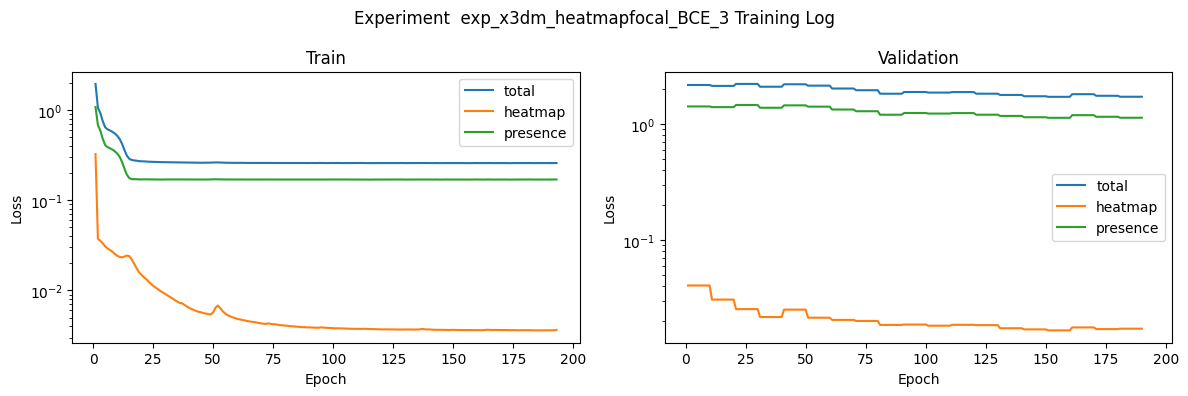

In [67]:

splits = {
    'Train': ('train_loss', 'train_heatmap_loss', 'train_presence_loss'),
    'Validation': ('val_loss', 'val_heatmap_loss', 'val_presence_loss'),
    #'Test': ('test_loss', 'test_heatmap_loss', 'test_presence_loss', 'test_presence_combined_loss')
}

log_df = pd.read_csv(LOG_PATH)

fig, axes = plt.subplots(1, len(splits), figsize=(6 * len(splits), 4), sharex=True)
if not isinstance(axes, (list, tuple, np.ndarray)):
    axes = [axes]

for ax, (title, cols) in zip(axes, splits.items()):
    epochs = log_df['epoch']
    plotted = False
    labels = []
    for metric in cols:
        if 'heatmap' in metric:
            labels.append('heatmap')
        elif 'presence_combined' in metric:
            labels.append('presence_combined')
        elif 'presence' in metric:
            labels.append('presence')
        else:
            labels.append('total')
    for metric, label in zip(cols, labels):
        series = log_df[metric].bfill()
        if series.notna().any():
            ax.plot(epochs[:], series[:], label=label)
            plotted = True
    ax.set_title(title)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    if plotted:
        ax.legend()
    else:
        ax.text(0.5, 0.5, 'N/A', transform=ax.transAxes, ha='center', va='center', fontsize=12)
    ax.set_yscale('log')

plt.suptitle('Experiment  {} Training Log'.format(LOG_PATH.parent.name))
plt.tight_layout()
plt.savefig(LOG_PATH.parent / 'training_log_plot.png')


## Eval metrics
Queste celle consumano `outputs/preds/metrics.json` e le curve PR/ROC generate da `infer.py` per dare un colpo d'occhio alle prestazioni sul manifest di valutazione.

In [33]:

METRICS_PATH = out_path / Path('metrics.json')
if not METRICS_PATH.exists():
    raise FileNotFoundError(f'Metrics file not found: {METRICS_PATH}')

with open(METRICS_PATH) as f:
    eval_metrics = json.load(f)

def summarize(name, metrics_dict):
    if not metrics_dict:
        return None
    return {
        'variant': name,
        'AUPRC': metrics_dict.get('auprc'),
        'ROC_AUC': metrics_dict.get('roc_auc'),
        'Precision@τ': metrics_dict.get('precision_at_tau'),
        'Recall@τ': metrics_dict.get('recall_at_tau'),
        'F1@τ': metrics_dict.get('f1_at_tau'),
        'τ usata': metrics_dict.get('threshold')
    }

presence_comb = eval_metrics.get('presence_metrics_combined', {})
presence_logit = eval_metrics.get('presence_metrics_logit', {})
rows = [r for r in (summarize('combined', presence_comb), summarize('logit', presence_logit)) if r]
presence_summary = pd.DataFrame(rows)
display(presence_summary)

for name, metrics_dict in [('combined', presence_comb), ('logit', presence_logit)]:
    if not metrics_dict:
        continue
    conf = metrics_dict.get('confusion_matrix', {})
    conf_df = pd.DataFrame(
        [[conf.get('tp', 0), conf.get('fp', 0)],
         [conf.get('fn', 0), conf.get('tn', 0)]],
        index=['GT=1', 'GT=0'],
        columns=['Pred=1', 'Pred=0']
    )
    display(conf_df)


variant     AUPRC  ROC_AUC  Precision@τ  Recall@τ      F1@τ  τ usata
0  combined  0.724724      0.5     0.449448       1.0  0.620164      0.5
1     logit  0.724724      0.5     0.449448       1.0  0.620164      0.5

Pred=1  Pred=0
GT=1    2116    2592
GT=0       0       0

Pred=1  Pred=0
GT=1    2116    2592
GT=0       0       0

### Curve PR e ROC
Se `--sweep-curves DIR` era attivo durante l'inferenza, le curve vengono salvate in CSV e visualizzate qui.

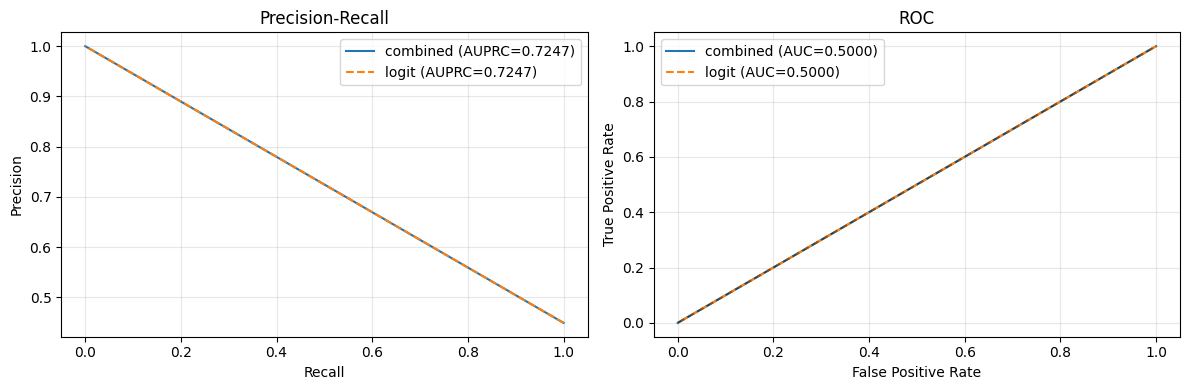

In [34]:

CURVES_DIR = out_path /  Path('curves')
pr_comb_path = CURVES_DIR / 'pr_curve_combined.csv'
roc_comb_path = CURVES_DIR / 'roc_curve_combined.csv'
pr_logit_path = CURVES_DIR / 'pr_curve_logit.csv'
roc_logit_path = CURVES_DIR / 'roc_curve_logit.csv'

if not (pr_comb_path.exists() and roc_comb_path.exists()):
    raise FileNotFoundError('Curve PR/ROC non trovate: assicurati di aver passato --sweep-curves e che i file *_combined.csv esistano.')

pr_comb_df = pd.read_csv(pr_comb_path)
roc_comb_df = pd.read_csv(roc_comb_path)
pr_logit_df = pd.read_csv(pr_logit_path) if pr_logit_path.exists() else None
roc_logit_df = pd.read_csv(roc_logit_path) if roc_logit_path.exists() else None

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# PR
if pr_comb_df is not None:
    ap_comb = pr_comb_df['pr_auc'].dropna().iloc[0] if 'pr_auc' in pr_comb_df else None
    axes[0].plot(pr_comb_df['recall'], pr_comb_df['precision'], label=f'combined (AUPRC={ap_comb:.4f})' if ap_comb is not None else 'combined')
if pr_logit_df is not None:
    ap_logit = pr_logit_df['pr_auc'].dropna().iloc[0] if 'pr_auc' in pr_logit_df else None
    axes[0].plot(pr_logit_df['recall'], pr_logit_df['precision'], label=f'logit (AUPRC={ap_logit:.4f})' if ap_logit is not None else 'logit', linestyle='--')
axes[0].set_xlabel('Recall')
axes[0].set_ylabel('Precision')
axes[0].set_title('Precision-Recall')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# ROC
if roc_comb_df is not None:
    auc_comb = roc_comb_df['roc_auc'].dropna().iloc[0] if 'roc_auc' in roc_comb_df else None
    axes[1].plot(roc_comb_df['fpr'], roc_comb_df['tpr'], label=f'combined (AUC={auc_comb:.4f})' if auc_comb is not None else 'combined')
if roc_logit_df is not None:
    auc_logit = roc_logit_df['roc_auc'].dropna().iloc[0] if 'roc_auc' in roc_logit_df else None
    axes[1].plot(roc_logit_df['fpr'], roc_logit_df['tpr'], label=f'logit (AUC={auc_logit:.4f})' if auc_logit is not None else 'logit', linestyle='--')
axes[1].plot([0, 1], [0, 1], 'k--', alpha=0.4)
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.savefig(LOG_PATH.parent / 'precision-recall-ROC.png')
plt.show()


## View heatmap

In [63]:
# --- View predicted heatmap + clip animation (T dimension) ---
from pathlib import Path
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML, display

import torch
import yaml


def find_repo_root(marker: str = "config/default.yml", max_depth: int = 6) -> Path:
    root = Path.cwd().resolve()
    for _ in range(max_depth):
        if (root / marker).exists():
            return root
        root = root.parent
    raise FileNotFoundError("config/default.yml non trovato; lancia il notebook dalla repo.")


REPO_ROOT = find_repo_root()
sys.path.insert(0, str(REPO_ROOT / "src"))

from cyclone_locator.datasets.med_fullbasin import MedFullBasinDataset
from cyclone_locator.models.simplebaseline import SimpleBaseline
from cyclone_locator.models.x3d_backbone import X3DBackbone


# 1) Config + checkpoint
cfg_default = yaml.safe_load(open(REPO_ROOT / "config/default.yml"))

# Scegli un checkpoint salvato da train.py (di default: best.ckpt)
ckpt_candidates = [
    out_path / "best.ckpt",
    out_path / "last.ckpt",
    out_path / "checkpoint.ckpt",
    out_path / "model.ckpt",
]
ckpt_path = next((p for p in ckpt_candidates if p.exists()), None)
if ckpt_path is None:
    raise FileNotFoundError(
        f"Nessun checkpoint trovato in {out_path}. "
        f"Imposta manualmente ckpt_path = Path('.../best.ckpt')."
    )

state = torch.load(ckpt_path, map_location="cpu")
cfg = state.get("cfg", cfg_default)
train_cfg = cfg.get("train", {})
data_cfg = cfg.get("data", {})
loss_cfg = cfg.get("loss", {})


# 2) Modello
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
backbone = train_cfg.get("backbone", "resnet18")
pretrained = bool(train_cfg.get("backbone_pretrained", True))
temporal_T = int(train_cfg.get("temporal_T", 1))

if str(backbone).startswith("x3d"):
    try:
        model = X3DBackbone(backbone=str(backbone), pretrained=pretrained)
    except ImportError as exc:
        raise ImportError(
            "Backbone x3d richiede pytorchvideo. Installa pytorchvideo oppure usa un backbone resnet.*"
        ) from exc
else:
    model = SimpleBaseline(backbone=str(backbone), temporal_T=temporal_T, pretrained=pretrained)

weights = state.get("model", state)
model.load_state_dict(weights, strict=True)
model.to(device).eval()


# 3) Dataset (val di default)
manifest_csv = REPO_ROOT / data_cfg.get("manifest_val", data_cfg.get("manifest_train"))
train_manifest_csv = REPO_ROOT / data_cfg.get("manifest_train", "")
meta_csv = REPO_ROOT / data_cfg.get("letterbox_meta_csv", "")

dataset = MedFullBasinDataset(
    csv_path=str(train_manifest_csv),
    image_size=int(train_cfg.get("image_size", 512)),
    heatmap_stride=int(train_cfg.get("heatmap_stride", 4)),
    heatmap_sigma_px=float(loss_cfg.get("heatmap_sigma_px", 8)),
    use_aug=False,
    use_pre_letterboxed=bool(data_cfg.get("use_pre_letterboxed", True)),
    letterbox_meta_csv=str(meta_csv) if str(meta_csv) else None,
    letterbox_size_assert=data_cfg.get("letterbox_size_assert"),
    temporal_T=int(train_cfg.get("temporal_T", 1)),
    temporal_stride=int(train_cfg.get("temporal_stride", 1)),
)


def show_pred_heatmap(sample_idx: int = 0, frame_t: int = 0):
    sample = dataset[int(sample_idx)]
    stride = int(train_cfg.get("heatmap_stride", 4))

    video = sample["video"].unsqueeze(0).to(device)
    image = sample["image"].unsqueeze(0).to(device)
    inp = video if getattr(model, "input_is_video", False) else image

    with torch.no_grad():
        hm_pred, presence_logit = model(inp)

    hm_pred = hm_pred.squeeze(0).squeeze(0)
    hm_pred_vis = torch.sigmoid(hm_pred).cpu().numpy()
    hm_tgt = sample["heatmap"].squeeze(0).squeeze(0).cpu().numpy()

    presence_gt = float(sample["presence"].item())

    infer_cfg = cfg.get("infer", {})
    use_peak = bool(train_cfg.get("presence_from_peak", False) or infer_cfg.get("presence_from_peak", False))
    tau = float(infer_cfg.get("peak_threshold") if use_peak and infer_cfg.get("peak_threshold") is not None else infer_cfg.get("presence_threshold", 0.5))

    presence_head_prob = float(torch.sigmoid(presence_logit).item())
    peak_logit = float(hm_pred.max().item())
    peak_prob = float(torch.sigmoid(torch.tensor(peak_logit)).item())

    presence_prob = peak_prob if use_peak else presence_head_prob
    presence_from_peak_prob = peak_prob
    presence_from_peak_pred = int(peak_prob >= tau)
    presence_pred = int(presence_prob >= tau)

    ty, tx = np.unravel_index(np.argmax(hm_tgt), hm_tgt.shape)
    py, px = np.unravel_index(np.argmax(hm_pred_vis), hm_pred_vis.shape)
    tx_lb, ty_lb = (tx + 0.5) * stride, (ty + 0.5) * stride
    px_lb, py_lb = (px + 0.5) * stride, (py + 0.5) * stride

    frames = sample["video"].permute(1, 2, 3, 0).cpu().numpy()  # (T,H,W,C)
    t = int(np.clip(frame_t, 0, frames.shape[0] - 1))
    frame = np.clip(frames[t], 0.0, 1.0)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(frame)
    axes[0].scatter([tx_lb], [ty_lb], c="cyan", s=60, marker="x", label="target peak")
    axes[0].scatter([px_lb], [py_lb], c="lime", s=60, marker="x", label="pred peak")
    axes[0].set_title(
        f"idx={sample_idx} | t={t}/{frames.shape[0]-1} | presence_gt={presence_gt:.3f} | prob={presence_prob:.3f} pred={presence_pred} | peak_prob={presence_from_peak_prob:.3f} peak_pred={presence_from_peak_pred} | tau={tau:.2f} | head_prob={presence_head_prob:.3f}"
    )
    axes[0].axis("off")
    axes[0].legend(loc="lower left")

    hm_tgt_im = axes[1].imshow(hm_tgt, cmap="magma", vmin=0, vmax=1)
    axes[1].set_title("Target heatmap")
    axes[1].axis("off")
    fig.colorbar(hm_tgt_im, ax=axes[1], fraction=0.046, pad=0.04)

    hm_pred_im = axes[2].imshow(hm_pred_vis, cmap="magma", vmin=0, vmax=1)
    axes[2].set_title("Pred heatmap (sigmoid)")
    axes[2].axis("off")
    fig.colorbar(hm_pred_im, ax=axes[2], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()


def show_pred_animation(
    sample_idx: int = 0,
    interval_ms: int = 200,
    repeat: bool = True,
    heatmap: str = "pred",  # "pred" | "target"
):
    sample = dataset[int(sample_idx)]
    stride = int(train_cfg.get("heatmap_stride", 4))

    video = sample["video"].unsqueeze(0).to(device)
    image = sample["image"].unsqueeze(0).to(device)
    inp = video if getattr(model, "input_is_video", False) else image

    with torch.no_grad():
        hm_pred, presence_logit = model(inp)

    hm_pred = hm_pred.squeeze(0).squeeze(0)
    hm_pred_vis = torch.sigmoid(hm_pred).cpu().numpy()
    hm_tgt = sample["heatmap"].squeeze(0).squeeze(0).cpu().numpy()

    presence_gt = float(sample["presence"].item())

    infer_cfg = cfg.get("infer", {})
    use_peak = bool(train_cfg.get("presence_from_peak", False) or infer_cfg.get("presence_from_peak", False))
    tau = float(infer_cfg.get("peak_threshold") if use_peak and infer_cfg.get("peak_threshold") is not None else infer_cfg.get("presence_threshold", 0.5))

    presence_head_prob = float(torch.sigmoid(presence_logit).item())
    peak_logit = float(hm_pred.max().item())
    peak_prob = float(torch.sigmoid(torch.tensor(peak_logit)).item())

    presence_prob = peak_prob if use_peak else presence_head_prob
    presence_from_peak_prob = peak_prob
    presence_from_peak_pred = int(peak_prob >= tau)
    presence_pred = int(presence_prob >= tau)

    ty, tx = np.unravel_index(np.argmax(hm_tgt), hm_tgt.shape)
    py, px = np.unravel_index(np.argmax(hm_pred_vis), hm_pred_vis.shape)
    tx_lb, ty_lb = (tx + 0.5) * stride, (ty + 0.5) * stride
    px_lb, py_lb = (px + 0.5) * stride, (py + 0.5) * stride

    frames = sample["video"].permute(1, 2, 3, 0).cpu().numpy()  # (T,H,W,C)
    T = int(frames.shape[0])

    center_abs = sample.get("image_path_abs")
    window_paths = dataset.temporal_selector.get_window(center_abs) if center_abs else None
    frame_names = [Path(p).name for p in window_paths] if window_paths else None

    hm_show = hm_pred_vis if heatmap == "pred" else hm_tgt
    hm_title = "Pred heatmap (sigmoid)" if heatmap == "pred" else "Target heatmap"

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    f0 = np.clip(frames[0], 0.0, 1.0)
    is_gray = (f0.ndim == 3 and f0.shape[2] == 1)
    if is_gray:
        frame_im = axes[0].imshow(f0[..., 0], cmap="gray", vmin=0, vmax=1)
    else:
        frame_im = axes[0].imshow(f0)

    axes[0].scatter([tx_lb], [ty_lb], c="lime", s=60, marker="x", label="target peak")
    axes[0].scatter([px_lb], [py_lb], c="red", s=60, marker="x", label="pred peak")
    name0 = frame_names[0] if frame_names else str(Path(sample.get("image_path", "")).name)
    axes[0].set_title(
        f"{name0} | idx={sample_idx} | t=0/{T-1} | presence_gt={presence_gt:.3f} | prob={presence_prob:.3f} pred={presence_pred} | peak_prob={presence_from_peak_prob:.3f} peak_pred={presence_from_peak_pred} | tau={tau:.2f} | head_prob={presence_head_prob:.3f}"
    )
    axes[0].axis("off")
    axes[0].legend(loc="lower left")

    hm_im = axes[1].imshow(hm_show, cmap="magma", vmin=0, vmax=1)
    axes[1].set_title(hm_title)
    axes[1].axis("off")
    fig.colorbar(hm_im, ax=axes[1], fraction=0.046, pad=0.04)
    plt.tight_layout()

    def update(t: int):
        f = np.clip(frames[t], 0.0, 1.0)
        if is_gray:
            frame_im.set_array(f[..., 0])
        else:
            frame_im.set_array(f)
        name = frame_names[t] if frame_names else str(Path(sample.get("image_path", "")).name)
        axes[0].set_title(
            f"{name} | idx={sample_idx} | t={t}/{T-1} | p_gt={presence_gt:.3f} | peak_prob={presence_from_peak_prob:.3f} peak_pred={presence_from_peak_pred}"
        )
        return (frame_im,)

    anim = animation.FuncAnimation(
        fig,
        update,
        frames=T,
        interval=int(interval_ms),
        blit=False,
        repeat=bool(repeat),
    )
    display(HTML(anim.to_jshtml()))
    plt.close(fig)


# Cambia sample_idx / frame_t a piacere
# show_pred_heatmap(sample_idx=3508, frame_t=0)
show_pred_animation(sample_idx=1347, interval_ms=200, repeat=True, heatmap="pred")
